# Import Dependencies

In [45]:
import time
import sys
import os
import pickle
import numpy as np
import xarray as xr
import pandas as pd

import pyxdf
# pyxdf depends on higher numpy version than snirf, this is a workaround if pyxdf and thus newer numpy is installed.
# CAREFUL: installing pyxdf will overwrite the numpy version in the cedalion environment and might requires this assignment anywhere in the following
np.float_ = np.float64

import matplotlib.pyplot as p
import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')

from IPython.display import Image

import cedalion
import cedalion.dataclasses as cdc

import cedalion.io
import cedalion.xrutils as xrutils
import cedalion.plots as plots  
from cedalion import units



# for dev purposes
%load_ext autoreload
%autoreload 2

%matplotlib widget

## Data loading directories and files
# local parent dir
dir = 'C:/Users/avonl/OneDrive/Work/Research/projects/2025 - DynNetworkDOT/data/'

#cluster
#dir =  '/home/avonluh/data/dyn_network/'
#dir =  '/home/space/ibs/datasets/raw_data/dynamic_dmn_dan/'

# subject ID
sbj_id = 'nc726'
#sbj_id = 'nc300'

# fnirs data
FNIRS_DATADIR = dir+sbj_id+'/ninja/'
# Photogrammetric Scan
PG_DATADIR = dir+sbj_id+'/scan/'
# Fluence Profile
FP_DATADIR = dir+sbj_id+'/fluence/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Helper function definitions

# Load Experiment Data (Naturalistic DMN-DAN Connectivity Changes)
This includes the snirf file without stimuli and the lsl xdf file with stimulus information and aux channels

In [46]:
record = cedalion.io.read_snirf(FNIRS_DATADIR+sbj_id+'.snirf')
rec = record[0]

display(rec)

streams, header = pyxdf.load_xdf(dir+sbj_id+'/'+'lsl.xdf')
for s in streams:
    name = s['info']['name'][0]
    n_samples = len(s['time_stamps'])
    ts = np.asarray(s.get('time_series', []))
    print(f"{name!r}: {n_samples} timestamps, data shape {ts.shape}")

<Recording |  timeseries: ['amp'],  masks: [],  stim: [],  aux_ts: ['digital', 'analog-1', 'analog-2', 'dark signal', 'temperature', 'GYRO_X', 'GYRO_Y', 'GYRO_Z', 'ACCEL_X', 'ACCEL_Y', 'ACCEL_Z'],  aux_obj: []>

'LiveAmpSN-102101-1018-STETriggerIn': 0 timestamps, data shape (0,)
'LiveAmpSN-102101-1018-DeviceTrigger': 0 timestamps, data shape (0,)
'PsychoPyMarker': 66 timestamps, data shape (66, 1)
'UnixTime_s': 6014 timestamps, data shape (6014, 1)
'HwSyncMarker': 3 timestamps, data shape (3, 1)
'LiveAmpSN-102101-1018': 2681174 timestamps, data shape (2681174, 5)
'Neon Companion_Neon Gaze': 1055763 timestamps, data shape (1055763, 16)
'Neon Companion_Neon Events': 4 timestamps, data shape (4, 1)


extract relevant stimulus information

In [47]:
psy = next(s for s in streams 
           if s['info']['name'][0] == 'PsychoPyMarker')
psy_times   = np.asarray(psy['time_stamps']) - psy['time_stamps'][0] 
psy_labels = [t[0] for t in psy['time_series']]
df_psy      = pd.DataFrame(dict(time=psy_times, label=psy_labels))

display(df_psy)


,time,label
0,0.000000,bhb_1_instr
1,62.842927,bhb_1_bh_1
2,77.857247,bhb_1_recovery_1
3,112.868815,bhb_1_bh_2
4,127.885573,bhb_1_recovery_2
...,...,...
61,5920.767806,bhb_2_recovery_4
62,5955.777727,bhb_2_bh_5
63,5970.792607,bhb_2_recovery_5
64,6005.801113,end


find start of experiment in fnirs recording and time shift that onset to t=0

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\indexes.py:523: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result = np.asarray(values)
c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\indexes.py:523: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result = np.asarray(values)


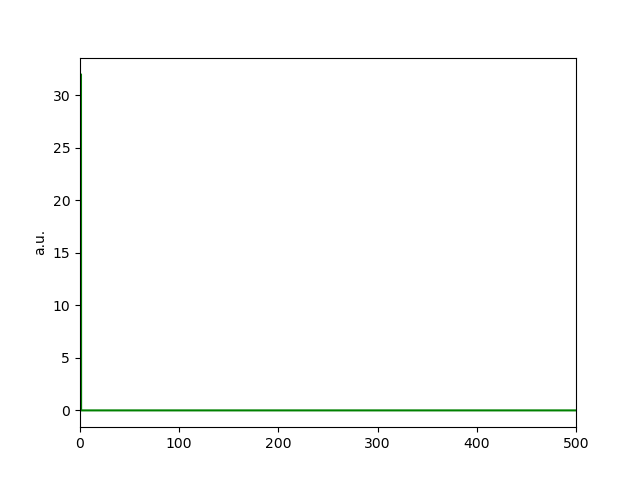

In [48]:
# identify experiment start by first trigger flank
thresh = 10
mask = rec.aux_ts['digital'] > thresh
i0 = mask.argmax(dim="time")
t_start = rec.aux_ts['digital']['time'].isel(time=i0)

## trim data and reset times to start at t_start for all signals in rec
# rec[amp]
t0 = rec["amp"].sel(time=t_start.item()*units.s, method = "nearest").time
rec["amp"] = rec["amp"].sel(time=slice(t0, None))
rec["amp"] = rec["amp"].assign_coords(time = rec["amp"].time - t0)
# rec.aux_ts
for name, da in rec.aux_ts.items():
    t0 = da.sel(time=t_start.item()*units.s, method = "nearest").time
    # 1) drop everything before t_start
    da2 = da.sel(time=slice(t0, None))
    # 2) shift time so that t_start → 0
    da2 = da2.assign_coords(time=da2.time - t0)
    # 3) put it back
    rec.aux_ts[name] = da2


fig, ax1 = p.subplots()

ax1.plot(rec.aux_ts['digital'].time, rec.aux_ts['digital'],
         color='green', lw=1.5,
         label='digital trigger')
ax1.set_ylabel("a.u.")
p.xlim(0, 500)
p.show()


## Add stimulus information to recording container .stim field

In [49]:
rec.stim["onset"] = df_psy["time"]
rec.stim["duration"] = df_psy["time"].diff().shift(-1).fillna(0)
rec.stim["value"] = 1.0
rec.stim["trial_type"] = df_psy["label"]

# remove _digit (e.g. "_1" from trial_type entries:
rec.stim["trial_type"] = rec.stim["trial_type"].str.replace(r'_\d{1,2}$', '', regex=True)

display(rec.stim)

,onset,duration,value,trial_type
0,0.000000,62.842927,1.0,bhb_1_instr
1,62.842927,15.014320,1.0,bhb_1_bh
2,77.857247,35.011569,1.0,bhb_1_recovery
3,112.868815,15.016758,1.0,bhb_1_bh
4,127.885573,35.007999,1.0,bhb_1_recovery
...,...,...,...,...
61,5920.767806,35.009921,1.0,bhb_2_recovery
62,5955.777727,15.014880,1.0,bhb_2_bh
63,5970.792607,35.008506,1.0,bhb_2_recovery
64,6005.801113,6.662437,1.0,end


## Verify via plot

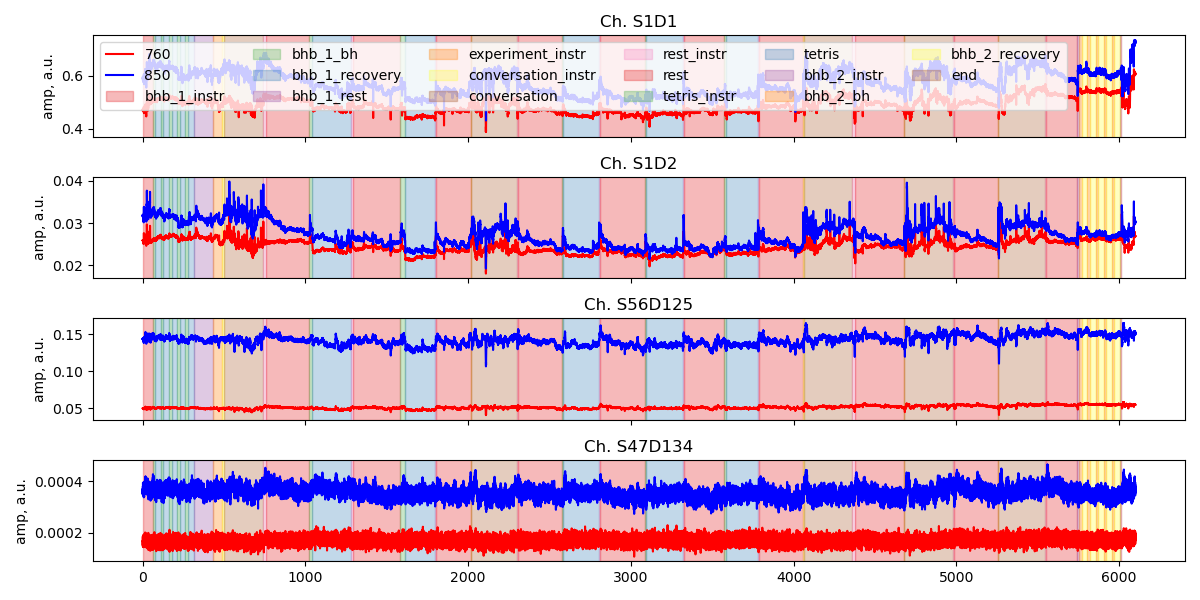

In [50]:
# select which time series we work with
ts1 = rec["amp"]
ts2 = rec.aux_ts["digital"]

# plot four channels and their stim markers
f, ax = p.subplots(4, 1, sharex=True, figsize=(12, 6))
for i, ch in enumerate(["S1D1", "S1D2", "S56D125", "S47D134"]):
    ax[i].plot(ts1.time, ts1.sel(channel=ch, wavelength="760"), "r-", label="760")
    ax[i].plot(ts1.time, ts1.sel(channel=ch, wavelength="850"), "b-", label="850")
    ax[i].set_title(f"Ch. {ch}")
    # add stim markers using Cedalion's plot_stim_markers function
    cedalion.plots.plot_stim_markers(ax[i], rec.stim, y=1)
    ax[i].set_ylabel(r"amp, a.u.")

ax[0].legend(ncol=6)
ax[3].set_label("time / s")
p.tight_layout()

# Save updated snirf file

In [51]:
record = cedalion.io.write_snirf(FNIRS_DATADIR+sbj_id+'_addedStim.snirf', rec)